The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


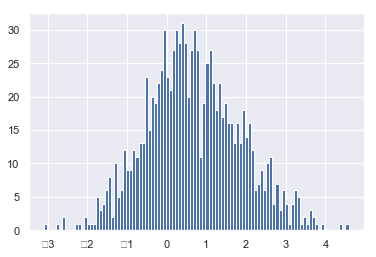

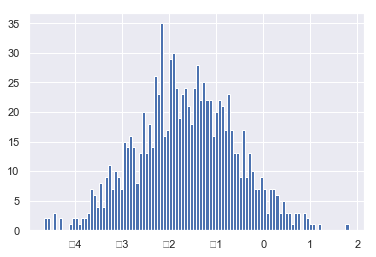

In [7]:
%run -i model.ipynb

In [11]:
import gpytorch

In [13]:
class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(1, 20))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(20, 20))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(20, 20))       
        self.add_module('relu3', torch.nn.ReLU())                  
        self.add_module('linear4', torch.nn.Linear(20, 1))         
                                                             
feature_extractor = LargeFeatureExtractor()

In [14]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, kernel):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(kernel),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

        def forward(self, x):
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
        
            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
kernel = gpytorch.kernels.RBFKernel(ard_num_dims=1)

In [17]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood, kernel=kernel)

NameError: name 'train_x' is not defined

In [18]:
model.train()
likelihood.train()

NameError: name 'model' is not defined

In [ ]:
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.1)

In [ ]:
def train(training_iterations = 60):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        
with gpytorch.settings.use_toeplitz(True):
    %time train()